# Проект: классификация

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype(float)

In [6]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df.balance.mean(),3)

1526.936

### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace('unknown',df.job.mode()[0] )
df['education'] = df['education'].replace('unknown',df.education.mode()[0] )

In [9]:
round(df[(df.job == df.job.mode()[0]) & (df.education == df.education.mode()[0])]['balance'].mean(),3)

1598.883

### Задание 6

In [10]:
# удалите все выбросы для признака balance
q1 = np.percentile(df.balance,25)
q3 = np.percentile(df.balance,75)
iqr = q3 - q1
low = q1-1.5*iqr
high = q3+1.5*iqr
df = df[(df.balance >= low) & (df.balance <= high)]

In [11]:
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

([<matplotlib.patches.Wedge at 0x19ae2d0f978>,
 [Text(-0.1267648739179658, 1.0926713443394416, 'no'),
  Text(0.12676487391796612, -1.0926713443394416, 'yes')],
 [Text(-0.06914447668252678, 0.5960025514578772, '53.7%'),
  Text(0.06914447668252698, -0.5960025514578772, '46.3%')])

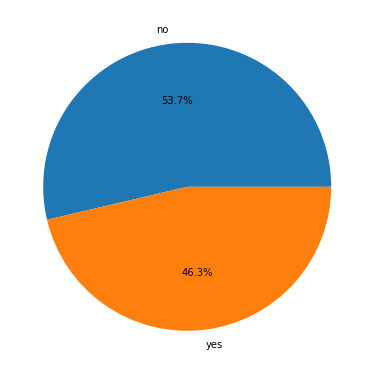

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
exited_counts = df.deposit.value_counts()

fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    exited_counts,
    labels = exited_counts.index,
    autopct = '%.1f%%'
)

### Задание 2

<AxesSubplot:>

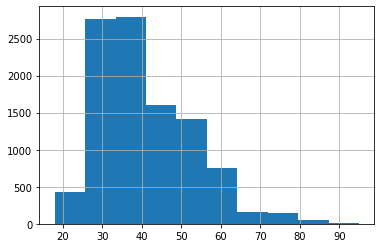

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.age.max()
df.age.hist()

<AxesSubplot:>

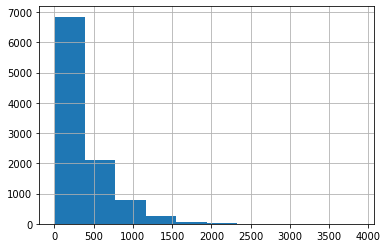

In [14]:
df.duration.min()
df.duration.hist()

<AxesSubplot:>

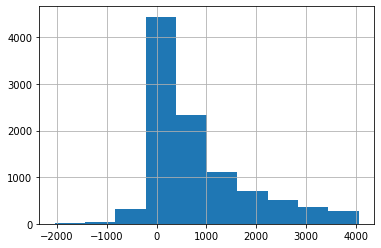

In [15]:
df.balance.hist()

### Задание 3

<AxesSubplot:>

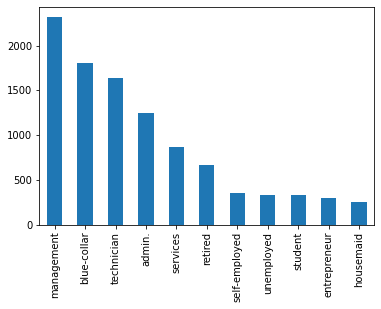

In [42]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.job.value_counts().plot(kind='bar')

<AxesSubplot:>

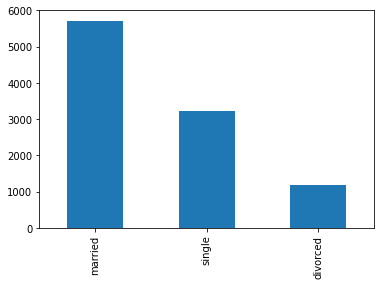

In [43]:
df.marital.value_counts().plot(kind='bar')

<AxesSubplot:>

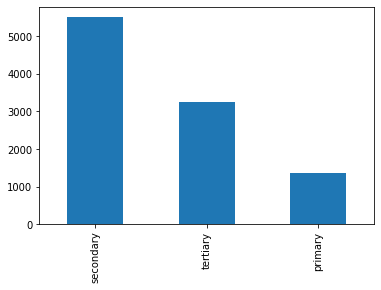

In [44]:
df.education.value_counts().plot(kind='bar')

<AxesSubplot:>

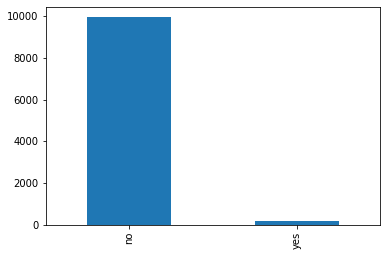

In [45]:
df.default.value_counts().plot(kind='bar')

<AxesSubplot:>

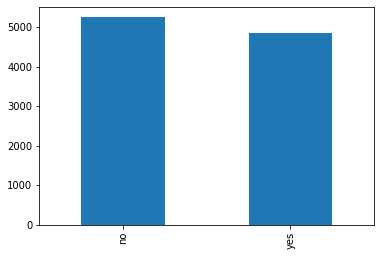

In [47]:
df.housing.value_counts().plot(kind='bar')

<AxesSubplot:>

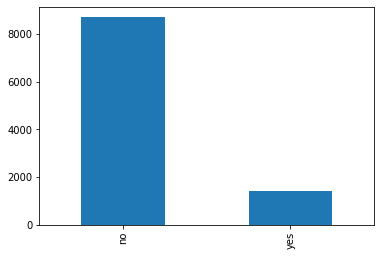

In [49]:
df.loan.value_counts().plot(kind='bar')

<AxesSubplot:>

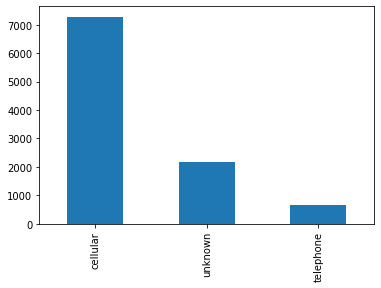

In [50]:
df.contact.value_counts().plot(kind='bar')

In [54]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 4

In [56]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 5

In [60]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby('month')['deposit'].value_counts(normalize = True)

month  deposit
apr    yes        0.618072
       no         0.381928
aug    no         0.559567
       yes        0.440433
dec    yes        0.903226
       no         0.096774
feb    yes        0.544429
       no         0.455571
jan    no         0.608150
       yes        0.391850
jul    no         0.589563
       yes        0.410437
jun    no         0.548913
       yes        0.451087
mar    yes        0.898734
       no         0.101266
may    no         0.678640
       yes        0.321360
nov    no         0.584615
       yes        0.415385
oct    yes        0.814925
       no         0.185075
sep    yes        0.834532
       no         0.165468
Name: deposit, dtype: float64

### Задание 6

In [99]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = ""
df['age_group'][df.age<30] = "<30"
df['age_group'][(df.age>=30) & (df.age < 40)] = "30-40"
df['age_group'] [(df.age>=40) & (df.age < 50)]= "40-50"
df['age_group'][(df.age>=50) & (df.age < 60)] = "50-60"
df['age_group'][df.age>=60] = "60+"
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


In [105]:
grouped_age = df.groupby('age_group')['deposit'].value_counts(normalize = True)
grouped_age

age_group  deposit
30-40      no         0.566776
           yes        0.433224
40-50      no         0.606213
           yes        0.393787
50-60      no         0.594921
           yes        0.405079
60+        yes        0.759571
           no         0.240429
<30        yes        0.591753
           no         0.408247
Name: deposit, dtype: float64

### Задание 7

In [109]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df.groupby("job")["deposit"].value_counts()

job            deposit
admin.         no          672
               yes         574
blue-collar    no         1155
               yes         652
entrepreneur   no          189
               yes         111
housemaid      no          153
               yes          99
management     no         1180
               yes        1135
retired        yes         432
               no          231
self-employed  no          197
               yes         161
services       no          523
               yes         345
student        yes         245
               no           81
technician     no          900
               yes         738
unemployed     yes         189
               no          143
Name: deposit, dtype: int64

In [112]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df.groupby("marital")["deposit"].value_counts(normalize = True)

marital   deposit
divorced  no         0.530161
          yes        0.469839
married   no         0.577953
          yes        0.422047
single    yes        0.534080
          no         0.465920
Name: deposit, dtype: float64

In [113]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df.groupby("education")["deposit"].value_counts(normalize = True)

education  deposit
primary    no         0.616753
           yes        0.383247
secondary  no         0.555737
           yes        0.444263
tertiary   yes        0.528867
           no         0.471133
Name: deposit, dtype: float64

### Задание 8

In [120]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_yes = df[df.deposit == "yes"]
df_no = df[df.deposit == "no"]

df_yes.groupby(["marital",'education'])['deposit'].value_counts()

marital   education  deposit
divorced  primary    yes          96
          secondary  yes         283
          tertiary   yes         174
married   primary    yes         339
          secondary  yes        1289
          tertiary   yes         784
single    primary    yes          82
          secondary  yes         879
          tertiary   yes         755
Name: deposit, dtype: int64

In [121]:
df_no.groupby(["marital",'education'])['deposit'].value_counts()

marital   education  deposit
divorced  primary    no           91
          secondary  no          370
          tertiary   no          163
married   primary    no          641
          secondary  no         1830
          tertiary   no          832
single    primary    no          100
          secondary  no          866
          tertiary   no          531
Name: deposit, dtype: int64

## Часть 3: преобразование данных

### Задание 1

In [129]:
# преобразуйте уровни образования
le = preprocessing.LabelEncoder()
le.fit(df.education)
df['education'] = le.transform(df.education)
df.education.sum()

11995

In [130]:
le = preprocessing.LabelEncoder()
le.fit(df.age_group)
df['age_group'] = le.transform(df.age_group)

In [131]:
lb = preprocessing.LabelBinarizer()
df.deposit = lb.fit_transform(df.deposit)

In [139]:
round(df.deposit.std(),3)

0.499

### Задание 2

In [147]:
# преобразуйте бинарные переменные в представление из нулей и единиц
lb = preprocessing.LabelBinarizer()
df.loan = lb.fit_transform(df.loan)
df.housing = lb.fit_transform(df.housing)
df.default = lb.fit_transform(df.default)

In [149]:
round(df.default.mean()+df.loan.mean()+df.housing.mean(),3)

0.635

### Задание 3

In [174]:
type_dummies1 = pd.get_dummies(df['job'])  
type_dummies2 = pd.get_dummies(df['marital'])  
type_dummies3 = pd.get_dummies(df['contact'])  
type_dummies4 = pd.get_dummies(df['month'])  
type_dummies5 = pd.get_dummies(df['poutcome'])  
df1 = pd.concat([df,type_dummies1,type_dummies2,type_dummies3,type_dummies4,type_dummies5],axis=1)

### Задание 4

<AxesSubplot:>

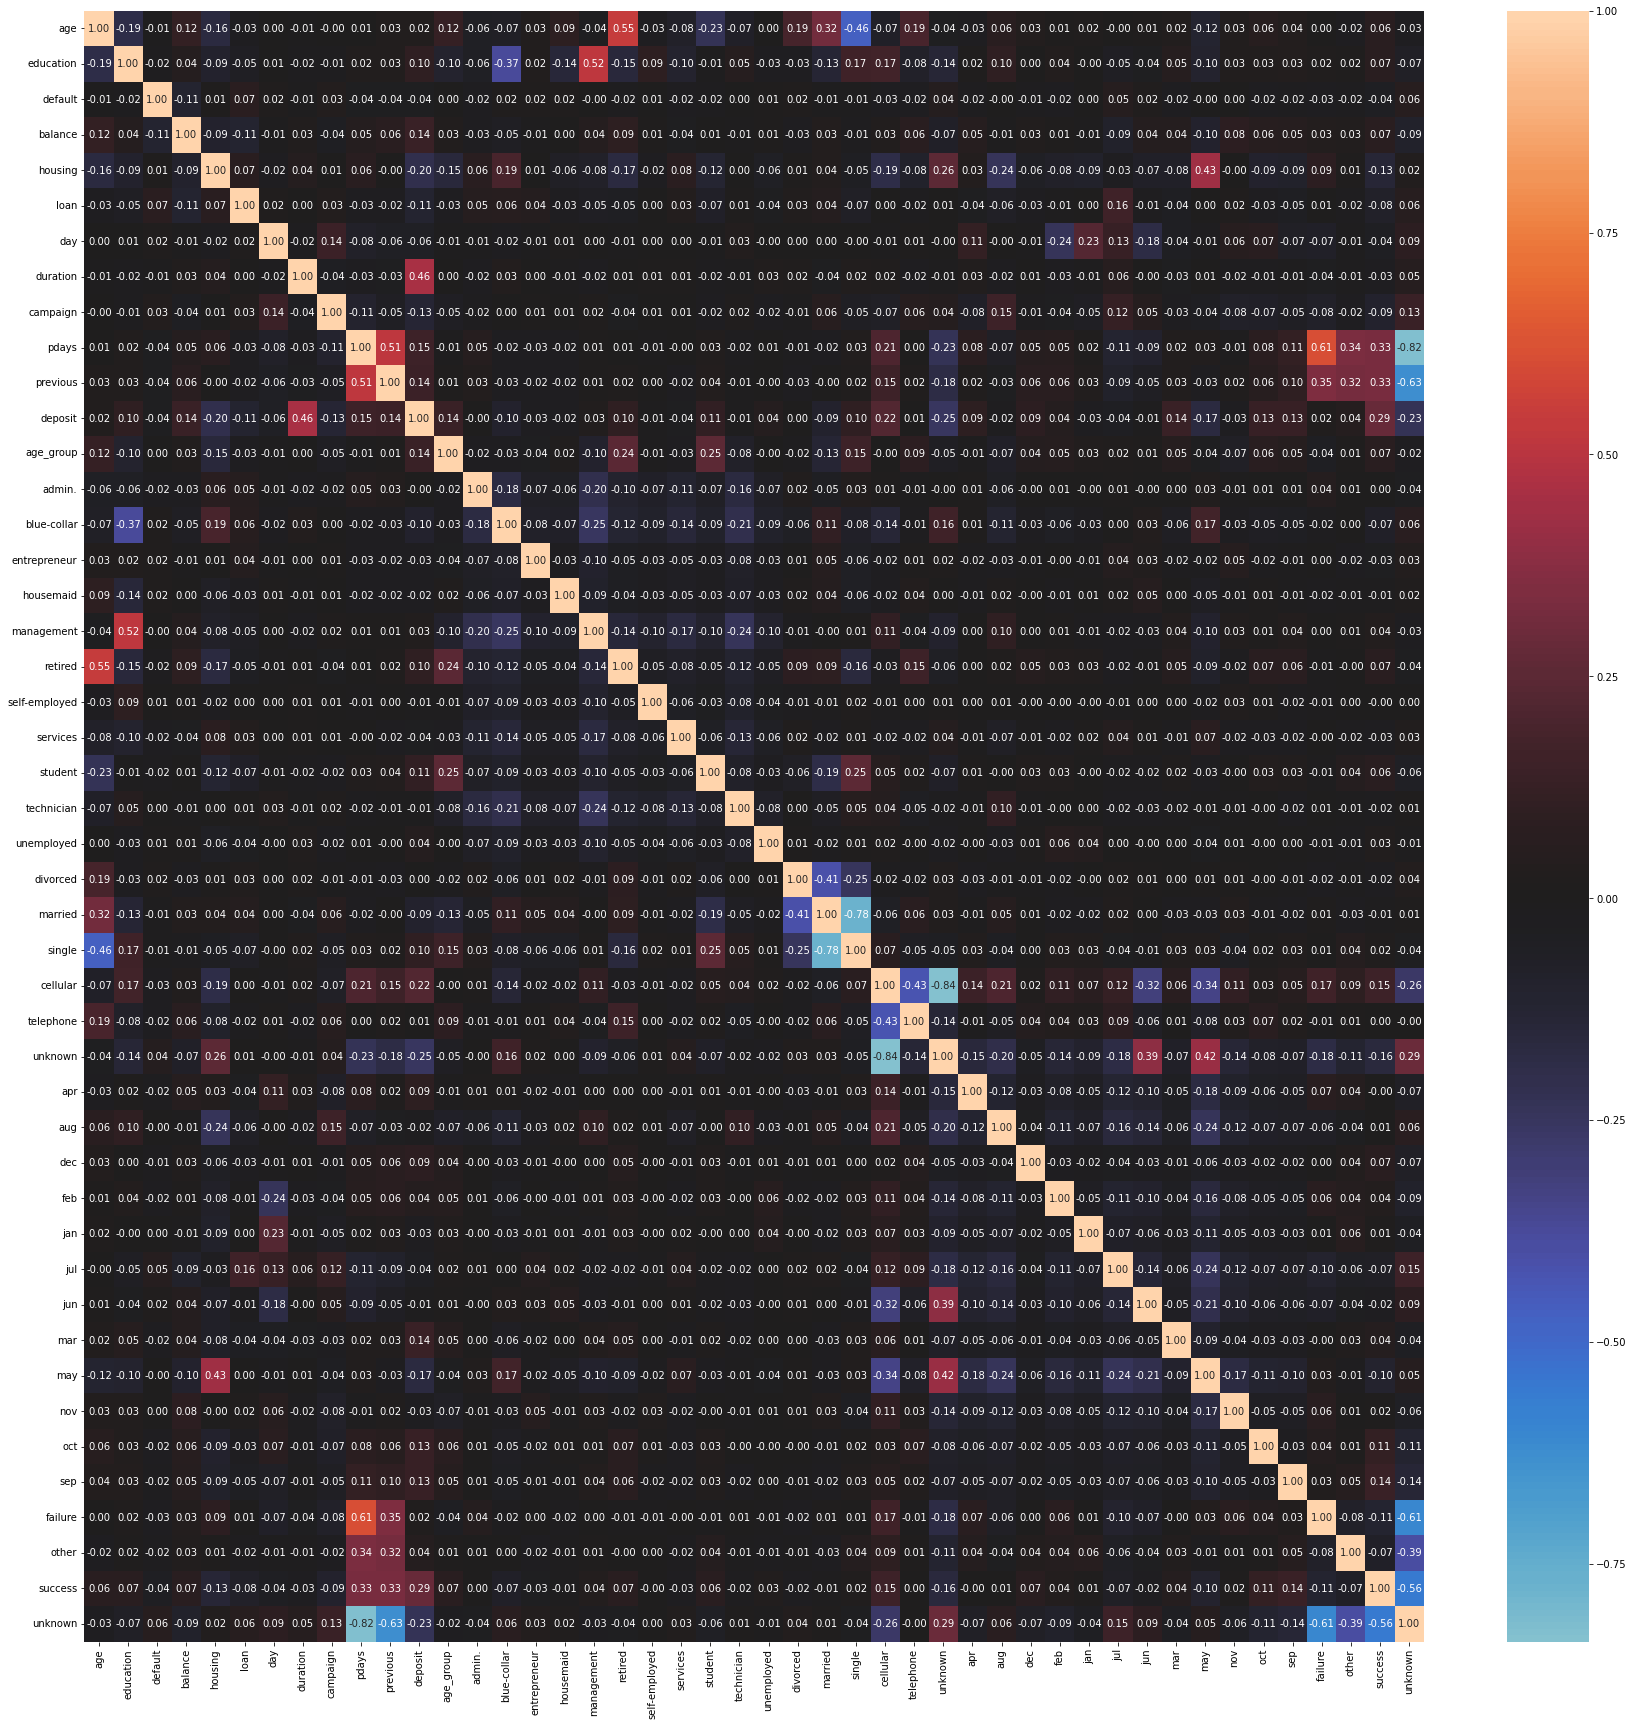

In [180]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30,30))  
sns.heatmap(df1.corr(),fmt='.2f',annot=True, center=0)

### Задание 5

In [183]:
X = df1.drop(['deposit'], axis=1)
y = df1['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [184]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 50)

In [187]:
X_test.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'age_group', 'admin.', 'blue-collar',
       'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed',
       'services', 'student', 'technician', 'unemployed', 'divorced',
       'married', 'single', 'cellular', 'telephone', 'unknown', 'apr', 'aug',
       'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep',
       'failure', 'other', 'success', 'unknown'],
      dtype='object')

In [186]:
round(y_test.mean(),2)

0.46

### Задание 6

In [193]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
X_train_new = SelectKBest(f_classif, k=15).fit_transform(X_train, y_train)

ValueError: could not convert string to float: 'management'

In [211]:
df2 = pd.get_dummies(df)
X = df2.drop(['deposit'], axis=1)
y = df2['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
features_columns = X_train.columns

In [232]:
selector = SelectKBest(f_classif, k=15)
X_new = selector.fit_transform(X_train, y_train)
features = X_train.columns.values[selector.get_support()]
X_train_new = X_train[features]
X_train_new.columns

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задание 7

In [250]:
# нормализуйте данные с помощью minmaxsxaler
#Scaling
scaler = MinMaxScaler()
scaler.fit(X_train_new)
X_train_new_scaled = pd.DataFrame(scaler.transform(X_train_new),columns= X_train_new.columns )

In [251]:
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns= X_test.columns )

In [325]:
round(X_test_scaled.iloc[0,].mean(),2)

0.22

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [327]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_new_scaled, y_train)
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_new_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [271]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth = 6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_new_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_new_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.81
Test: 0.80


### Задание 2

In [35]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 3

In [273]:
from sklearn.model_selection import GridSearchCV

In [279]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]}
            
grid_search_forest = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state = 42,criterion='entropy'), 
   param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_new_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_new_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

Wall time: 434 ms
f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [287]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=42)

#Обучаем модель
rf.fit(X_train_new_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_new_scaled)
print('Train f1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test f1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train f1: 0.85
Test f1: 0.82
Test accuracy: 0.82
Test recall: 0.89


In [284]:
X_train_new_scaled.shape

(6770, 15)

### Задание 2

In [301]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [286]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = GradientBoostingRegressor(
    learning_rate = 0.05,
    max_depth=5,
    n_estimators=300,
    min_samples_leaf = 5,
    random_state=42 
)
gb.fit(X_train_new_scaled, y_train)

gb_pred  = gb.predict(X_test_scaled)

y_train_pred = rf.predict(X_train_new_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.85
Test: 0.82


### Задание3

In [298]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV


In [303]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', linear_model.LogisticRegression()),
    ('dt',  tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth = 6,
        random_state=42)),
    ('gb',GradientBoostingClassifier(
        learning_rate = 0.05,
        max_depth=5,
        n_estimators=300,
        min_samples_leaf = 5,
        random_state=42))
]

#Создаем объект класса стекинг
reg = StackingClassifier (
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(n_estimators=100, 
                                          max_depth = 10,
                                          random_state=42)
)
#Обучаем модель
reg.fit(X_train_new_scaled, y_train)

StackingClassifier(estimators=[('log_reg', LogisticRegression()),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=RandomForestClassifier(max_depth=10,
                                                          random_state=42))

In [304]:
y_pred_stack = reg.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.precision_score(y_test, y_pred_stack)))

Test: 0.76


### Задание 4

In [40]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [307]:
import optuna

In [310]:
random_state = 42

In [311]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [312]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-06-14 22:44:54,686] A new study created in memory with name: RandomForestClassifier
[I 2022-06-14 22:44:55,916] Trial 0 finished with value: 0.9002937084557119 and parameters: {'n_estimators': 149, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9002937084557119.
[I 2022-06-14 22:44:57,124] Trial 1 finished with value: 0.8997509339975093 and parameters: {'n_estimators': 157, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9002937084557119.
[I 2022-06-14 22:44:58,388] Trial 2 finished with value: 0.9568897946386581 and parameters: {'n_estimators': 137, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9568897946386581.
[I 2022-06-14 22:45:00,072] Trial 3 finished with value: 0.8948023653906008 and parameters: {'n_estimators': 184, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9568897946386581.
[I 2022-06-14 22:45:01,916] Trial 4 finished with value: 0.9292929292929293 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.96
Wall time: 34.7 s


In [314]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_new_scaled, y_train)
y_train_pred = model.predict(X_train_new_scaled)
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82
accuracy_score на тестовом наборе: 0.82
